###### Effective Field Theory

In [1]:
using Revise
using Plots
using Scattering
using ProgressBars
using LaTeXStrings
import PyPlot
using PyCall
const plt = PyPlot;
using DelimitedFiles
using DataFrames
using Statistics
using Optim
#pygui(true)
#%matplotlib inline

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Warning: Module JSON with build ID 2525595450401 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Info: Skipping precompilation since __precompile__(false). Importing Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80].
└ @ Base loading.jl:1034
┌ Info: Precompiling ProgressBars [49802e3a-d2f1-5c88-81d8-b72133a6f568]
└ @ Base loading.jl:1278
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Warning: Module Conda with build ID 2526507824914 is missing from the cache.
│ This may mean Conda [8f4d0f93-b110-5947-807f-2305c1781a2d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Warning: Module Conda with build ID 2526507824914 is missing from the cache.
│ This may mean Conda [8f4d0

# Setup

In [2]:
function savefig(fig, name; dpi=196, kwargs...)
    path = joinpath("../latex/Figures/", name)
    fig.savefig(path, dpi=dpi, kwargs...)
end

function cmap(name, number)
    cm = plt.cm.get_cmap(name)
    Ncolors = min(cm.N, number)
    mapcolors = [cm(round(Int, x*cm.N/Ncolors)) for x in 1:Ncolors]
end
++(a, b) = append!(collect(a), collect(b))

++ (generic function with 1 method)

In [3]:
raw = readdlm("../../project1/data/data.csv")
head, body = Symbol.(raw[1, :]), Float64.(raw[2:end, :])
data = DataFrame(body, head);
@show head;

head = [:T, :pwa93, :esc96, :nijm1, :nijm2, :nijm93]


In [4]:
# Reduced mass of n+p in lab frame in units [fm⁻¹]
mass = 2*(mₙ*mₚ)/(mₙ+mₚ) /197  

4.768621711440031

Create a function to do the book-keeping for RMatrix calculation and VPA calculation

In [5]:
function computephase(V::Potential; method::Scattering.Method=RMatrix(50),
         startpoint=1e-3, midpoint=0.01, endpoint=2, spacing=:log)
    # Logspaced points to introduce a bias in the error function
    # towards the low energy region
    E = if spacing == :log
        10 .^(range(log10(startpoint), log10(endpoint), length=100))
    else
        [range(startpoint, midpoint, length=50)..., 
        (10 .^(range(log10(midpoint), stop=log10(endpoint), length=50)))...]
    end
    k = .√(mass/197*E)
    δ = phaseshift(k, mass, V, method)
    2E, δ
end
computephase(V::Potential, m::Scattering.Method; kwargs...) = computephase(V; method=m, kwargs...)

computephase (generic function with 2 methods)

Compute an "exact" phase shift for comparison. This is used to construct a factory function which creates the error function and handles all of the book keeping of creating a potential, inserting the coefficients and computing the mean square error.

In [41]:
E_fit, δReid_fit = computephase(Reid());
MSE(x, y) = mean((x.-y).^2)

function makeerrorfunction(V::Type{<:Potential}; method::Scattering.Method=RMatrix(50), Λ=0.7,
    kwargs...)
    function error(coeffs)::Float64
        W = regularize(V(coeffs...), Λ)
        _, δ = computephase(W, method; kwargs...)
        MSE(δ, δReid_fit)
    end
    return error
end
makeerrorfunction(V::Type{<:Potential}, method::Scattering.Method; kwargs...) = makeerrorfunction(V; method=method, kwargs...)

makeerrorfunction (generic function with 2 methods)

Revise.LogRecord(Error, evaluation error starting at /home/erdos/.julia/packages/StaticArrays/l7lu2/src/SVector.jl:70, lowered, Revise_e943ed8b, "/home/erdos/.julia/packages/Revise/BqeJF/src/lowered.jl", 106, (mod=OrdinaryDiffEq, ex=begin
    #= /home/erdos/.julia/packages/OrdinaryDiffEq/C72aU/src/bdf_utils.jl:72 =#
    const global γₖ = #= /home/erdos/.julia/packages/OrdinaryDiffEq/C72aU/src/bdf_utils.jl:72 =# @SVector([sum((1 // j for j = 1:k)) for k = 1:6])
end)UndefVarError: ##4848 not defined
Stacktrace:
 [1] macro expansion at /home/erdos/.julia/packages/JuliaInterpreter/RmxVj/src/interpret.jl:60 [inlined]
 [2] methods_by_execution!(::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::JuliaInterpreter.Frame, ::BitArray{1}; define::Bool, skip_include::Bool) at /home/erdos/.julia/packages/Revise/BqeJF/src/lowered.jl:259)

Find optimal coefficient for Leading order potential

In [7]:
@show typeof(VPA()) <: Scattering.Method
@time computephase(Reid(), VPA((1e-4, 15.0)))
@time computephase(Reid(), RMatrix(50))

typeof(VPA()) <: Scattering.Method = true
 11.368142 seconds (36.16 M allocations: 1.637 GiB, 4.83% gc time)
  0.160219 seconds (1.05 M allocations: 124.624 MiB, 15.01% gc time)


([0.002, 0.0021596020596516222, 0.002331940528025765, 0.0025180317836547665, 0.002718973313124541, 0.002935950183580777, 0.0031702420317478025, 0.0034232306106783492, 0.003696407938741722, 0.003991385098909615  …  2.0043167476336676, 2.1642632881919543, 2.3369737274038687, 2.5234666375265618, 2.724841873932258, 2.9422870615845453, 3.1770845991421517, 3.4306192219974196, 3.7043861688530364, 4.0], [5.0721100464514, 5.2692542209264195, 5.473949968240137, 5.686473130008841, 5.907108000633861, 6.1361473828867155, 6.373892615863421, 6.620653571387109, 6.876748610638527, 7.142504498558739  …  60.26868902543092, 60.48965555734601, 60.67597607197133, 60.82757439957381, 60.94439616988377, 61.02640494273869, 61.07357848106673, 61.08590514609737, 61.06338042585344, 61.00600348895319])

In [8]:
erf = makeerrorfunction(LO)
Cs = [-106/197]
results_LO = optimize(erf, -1.0, 1.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-1.000000, 1.000000]
 * Minimizer: -5.309185e-01
 * Minimum: 8.727619e-02
 * Iterations: 16
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 17

In [27]:
@show C0 = Optim.minimizer(results_LO)[1]
V = LO(C0)
V = regularize(V, 0.7)
_, δLO_fit = computephase(V)
E, δLO = computephase(V, endpoint=10);

C0 = (Optim.minimizer(results_LO))[1] = -0.530918501342221


Find optimal coefficient for Next Leading order potential

In [10]:
erf = makeerrorfunction(NLO)
Cs = [C0, -10.3934/197.0]
results_NLO = optimize(erf, fill(-1.0, 2), fill(1.0, 2), Cs)

 * Status: success

 * Candidate solution
    Final objective value:     3.099066e-02

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.62e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   52  (vs limit Inf)
    Iterations:    5
    f(x) calls:    275
    ∇f(x) calls:   275


In [19]:
@show C0, C2 = Optim.minimizer(results_NLO)
V = NLO(C0, C2)
V = regularize(V, 0.7)
_, δNLO_fit = computephase(V)
E, δNLO = computephase(V, endpoint=10)

(C0, C2) = Optim.minimizer(results_NLO) = [-0.518555590410205, -0.05771998068001786]


([0.002, 0.002194997530986111, 0.0024090070805175647, 0.0026438822969320572, 0.0029016575569918803, 0.0031845655866821845, 0.003495056800015366, 0.0038358205233449774, 0.00420980828902404, 0.004620259400166321  …  8.657522562166116, 9.501620324205593, 10.428016575999369, 11.444735318700435, 12.560582883668506, 13.785224208699393, 15.129266551092577, 16.60435136263949, 18.223255122309784, 20.0], [5.0350045858517785, 5.273154574892038, 5.522407270526561, 5.783256354586929, 6.056213908336174, 6.3418105573093655, 6.640595522077706, 6.953136557470076, 7.280019760531071, 7.621849225042064  …  53.916559609737675, 52.56966949121705, 51.06710442244947, 49.39938064541609, 47.55711969195872, 45.531445828313046, 43.31454070772271, 40.90040258857115, 38.28586804666565, 35.4719639877958])

Find optimal coefficient for Next-to-Next Leading order potential

In [20]:
erf = makeerrorfunction(NNLO)
Cs = [C0, C2, -0.05]
#results_NNLO = optimize(erf, Cs, BFGS())
lower = [-1.0, -1.0, -1.0]
upper = [1.0, 1.0, 1.0]
inner_optimizer = GradientDescent()
#results_NNLO = optimize(erf, lower, upper, Cs)
results_NNLO = optimize(erf, lower, upper, Cs, SAMIN(verbosity=1))
#results_NNLO = optimize(erf, lower, upper, Cs, Fminbox(inner_optimizer))

SAMIN results
NO CONVERGENCE: MAXEVALS exceeded

     Obj. value:           0.02914

       parameter      search width
        -0.51560           0.50000 
        -0.01035           1.00000 
        -0.20095           2.00000 


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     2.914445e-02

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   153  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1000
    ∇f(x) calls:   0


In [24]:
@show C0, C2, C4 = Optim.minimizer(results_NNLO)
V = NNLO(C0, C2, C4)
V = regularize(V, 0.7)
_, δNNLO_fit = computephase(V)
E, δNNLO = computephase(V, endpoint=10)

(C0, C2, C4) = Optim.minimizer(results_NNLO) = [-0.5156016345682695, -0.010345538145899596, -0.20095076716940075]


([0.002, 0.002194997530986111, 0.0024090070805175647, 0.0026438822969320572, 0.0029016575569918803, 0.0031845655866821845, 0.003495056800015366, 0.0038358205233449774, 0.00420980828902404, 0.004620259400166321  …  8.657522562166116, 9.501620324205593, 10.428016575999369, 11.444735318700435, 12.560582883668506, 13.785224208699393, 15.129266551092577, 16.60435136263949, 18.223255122309784, 20.0], [5.051185136821325, 5.290089169973414, 5.540129391664408, 5.801800724085465, 6.075616497195512, 6.362108586940942, 6.661827458177603, 6.975342094670581, 7.303239796278502, 7.646125820962511  …  54.461267447999354, 53.189609303200804, 51.77031265136241, 50.19406178987443, 48.45141342207219, 46.53309843135579, 44.430454459291575, 42.13603215428783, 39.644429608302765, 36.9534224388524])

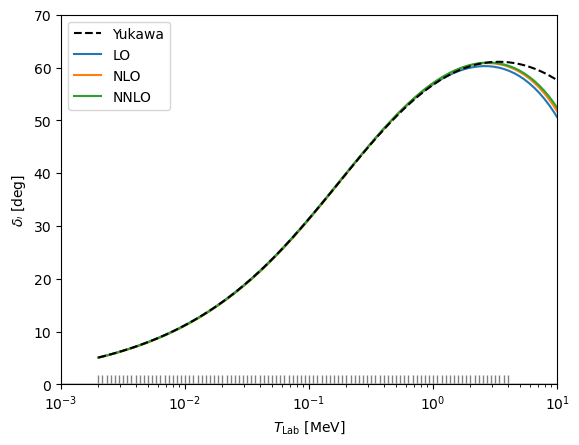

PyObject <matplotlib.legend.Legend object at 0x7fe832cfcdf0>

In [28]:
fig, ax = plt.subplots()
_, δReid = computephase(Reid(), endpoint=maximum(E/2));
#ax.plot(data[:T], data[:nijm93], label="nijm93", "-o")
ax.plot(E, δReid, label="Yukawa", linestyle="--", c="k", zorder=10)
ax.plot(E, δLO, label="LO")
ax.plot(E, δNLO, label="NLO")
ax.plot(E, δNNLO, label="NNLO")
ax.plot(E_fit, ones(length(E_fit)), "|", color="grey")
ax.set_xlim(1e-3, 10)
ax.set_ylim(0, 70)
ax.axhline(y=0, c="k", linewidth=1)
ax.set_xlabel(L"$T_{\mathrm{Lab}}$ [MeV]")
ax.set_ylabel(L"$δₗ$ [deg]")
ax.set_xscale("log")
ax.legend()

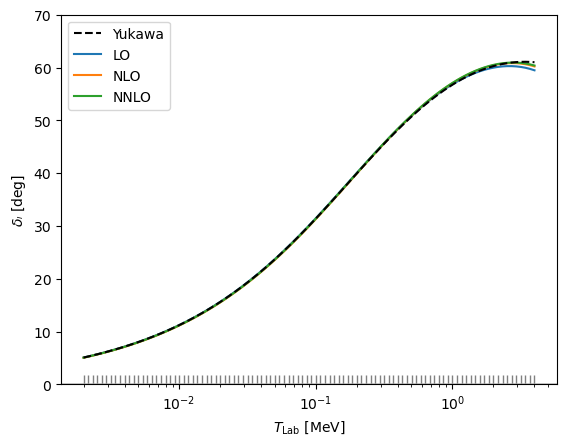

PyObject <matplotlib.legend.Legend object at 0x7fe828ff9460>

In [32]:
fig, ax = plt.subplots()
#ax.plot(data[:T], data[:nijm93], label="nijm93", "-o")
ax.plot(E_fit, δReid_fit, label="Yukawa", linestyle="--", c="k", zorder=10)
ax.plot(E_fit, δLO_fit, label="LO")
ax.plot(E_fit, δNLO_fit, label="NLO")
ax.plot(E_fit, δNNLO_fit, label="NNLO")
ax.plot(E_fit, ones(length(E_fit)), "|", color="grey")
ax.set_ylim(0, 70)
ax.axhline(y=0, c="k", linewidth=1)
ax.set_xlabel(L"$T_{\mathrm{Lab}}$ [MeV]")
ax.set_ylabel(L"$δₗ$ [deg]")
ax.set_xscale("log")
ax.legend()

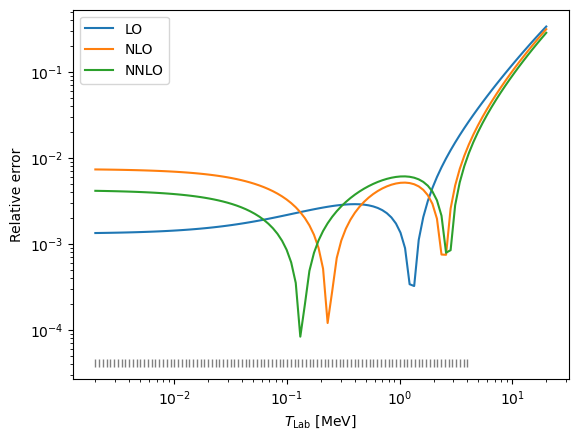

PyObject <matplotlib.legend.Legend object at 0x7fe828ec5820>

In [33]:
fig, ax = plt.subplots()
#ax.plot(data[:T], data[:nijm93], label="nijm93", "-o")
fiterr(x) = @. abs(δReid - x) / δReid
LOerr = fiterr(δLO)
NLOerr = fiterr(δNLO)
NNLOerr = fiterr(δNNLO)
ax.plot(E, LOerr, label="LO")
ax.plot(E, NLOerr, label="NLO")
ax.plot(E, NNLOerr, label="NNLO")
offset = (min([minimum(x) for x in [LOerr, NLOerr, NNLOerr]]...)) / 2
ax.plot(E_fit, offset * ones(length(E_fit)), "|", color="grey")
#ax.set_xlim(0, 10)
ax.axhline(y=0, c="k", linewidth=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"$T_{\mathrm{Lab}}$ [MeV]")
ax.set_ylabel("Relative error")
ax.legend()

In [15]:
map(Optim.minimizer, [results_LO, results_NLO, results_NNLO])

LoadError: UndefVarError: results_NNLO not defined

Do a line search for different value of $\Lambda$

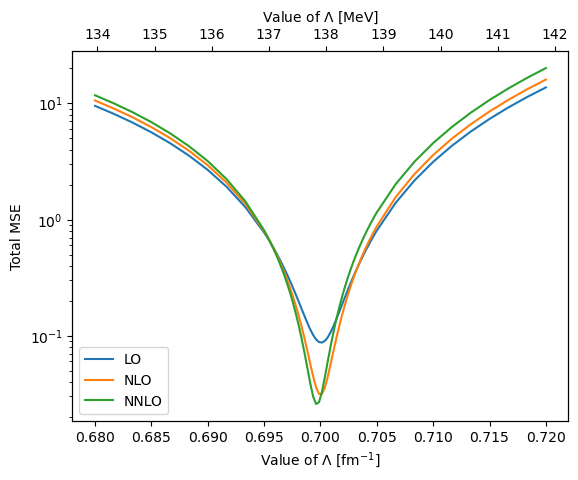

PyObject <matplotlib.legend.Legend object at 0x7fe82919cb20>

In [36]:
function lambda_search(V::Type{<:Potential}, coeff, Λrange)
    V_ = V(coeff...)
    errs = []
    errs_pointwise = []
    E = []
    for λ in Λrange
        V = regularize(V_, λ)
        E, δ = computephase(V)
        push!(errs, MSE(δ, δReid_fit))
        push!(errs_pointwise, @. abs(δReid_fit - δ)/δReid_fit)
    end
    errs, errs_pointwise, E
end

fig, ax = plt.subplots()
ax_E = ax.twiny()
function callback(ax)
    x1, x2 = ax.get_xlim()
    ax_E.set_xlim(x1*197, x2*197)
    ax_E.figure.canvas.draw()
end
ax.callbacks.connect("xlim_changed", callback)

Λs = [range(0.68, 0.695, length=10)..., range(0.695, 0.705, length=40)..., 
    range(0.705, 0.72, length=10)...]
#Λs = range(0.6, 0.8, length=5)
Vs = [LO, NLO, NNLO]
Cs = map(Optim.minimizer, [results_LO, results_NLO, results_NNLO])
labels = ["LO", "NLO", "NNLO"]
for (V_, C, label) in zip(Vs, Cs, labels)
    errs, _, _ = lambda_search(V_, C, Λs)
    ax.plot(Λs , errs, label=label)
end
ax.set_yscale("log")
ax.set_xlabel(L"Value of Λ [fm$^{-1}$]")
ax.set_ylabel("Total MSE")
ax_E.set_xlabel(L"Value of $\Lambda$ [MeV]")
ax.legend()


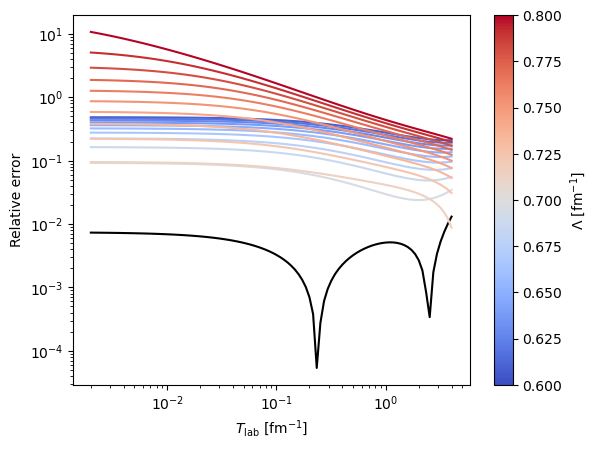

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe828ae1c40>

In [37]:
lambdas = 0.6:0.01:0.8
C = Optim.minimizer(results_NLO)
_, errs, Eerr = lambda_search(NLO, C, lambdas)
fig, ax = plt.subplots()
cm = cmap("coolwarm", length(lambdas))
for i in 1:length(errs)
    if lambdas[i] == 0.7
        ax.plot(Eerr, errs[i], color="k")
    else
        ax.plot(Eerr, errs[i], label="$(lambdas[i])", color=cm[i])
    end
end
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"$T_\mathrm{lab}$ [fm$^{-1}$]")
ax.set_ylabel("Relative error")
#ax2.legend()
mpl = pyimport("matplotlib")
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=mpl.colors.Normalize(vmin=minimum(lambdas), 
        vmax=maximum(lambdas)))
plt.colorbar(sm, ax=ax, label=L"$\Lambda$ [fm$^{-1}$]")

In [38]:
fig, ax = plt.subplots()
cm = cmap("Blues", length(errs_pointwise))
for (i, E) in enumerate(errs_pointwise)
    ax.plot(E_fit, E, color=cm[i],  label="$(Λs[i])")
end
ax.set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
ax.set_ylabel("Total MSE")
ax.legend()

LoadError: UndefVarError: errs_pointwise not defined

In [40]:
C0s = Optim.minimizer((-0.1:0.005:0.1)
δs = []
for C0 in C0s
    V = regularize(LO(C0), 0.7)
    E, δ = rmatrix(V)
    push!(δs, δ)
end

LoadError: syntax: missing comma or ) in argument list

In [20]:
fig, ax = plt.subplots()
cm = cmap("RdBu", length(C0s))
for i in 1:length(C0s)
    ax.plot(E, δs[i], color=cm[i])
end
ax.plot(E, δReid, color="k", "--")
mpl = pyimport("matplotlib")
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=mpl.colors.Normalize(vmin=-0.6, vmax=-0.4))
plt.colorbar(sm, ax=ax)

LoadError: UndefVarError: C0s not defined

# Pion interaction

In [110]:
E_fit, δReid_fit = computephase(Reid());
MSE(x, y) = mean((x.-y).^2)

function makeerrorfunctionpion(V; method::Scattering.Method=RMatrix(50), Λ=0.8)
    function error(coeffs)::Float64
        C = coeffs[1:end-1]
        Vπ = coeffs[end]
        W = regularize(V(C...) + Pion(Vπ), Λ)
        _, δ = computephase(W, method)
        MSE(δ, δReid_fit)
    end
    return error
end
makeerrorfunctionpion(V::Potential, m::Scattering.Method; kwargs...) = makeerrorfunctionpion(V; method=m, kwargs...)

makeerrorfunctionpion (generic function with 2 methods)

In [111]:
erf = makeerrorfunctionpion(LO)
# RMatrix: -0.4199, -0.02524
initial = [-0.5, 0.1]
lower = [-1.0, -1.0]
upper = [1.0, 1.0]
results_LO = optimize(erf, lower, upper, initial)

LoadError: TypeError: in keyword argument method, expected Scattering.Method, got a value of type typeof(method)

In [90]:
@show C0, Vπ = Optim.minimizer(results_LO)
V = LO(C0) + Pion(Vπ)
V = regularize(V, 0.8)
_, δLO_fit = rmatrix(V)
E, δLO = rmatrix(V, endpoint=5);

(C0, Vπ) = Optim.minimizer(results_LO) = [-0.41989518841517753, -0.025241534654457616]


In [86]:
erf = makeerrorfunctionpion(NLO)
initial = [-0.5, -0.05, 0.1]
lower = [-1.0, -0.5, -1.0]
upper = [1.0, 0.5 , 1.0]
results_NLO = optimize(erf, lower, upper, initial)

 * Status: success

 * Candidate solution
    Final objective value:     2.569525e-05

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.97e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   305  (vs limit Inf)
    Iterations:    8
    f(x) calls:    1455
    ∇f(x) calls:   1455


In [ ]:
@show C0, C2, Vπ = Optim.minimizer(results_NLO)
V = NLO(C0, C2) + Pion(Vπ)
V = regularize(V, 0.8)
_, δNLO_fit = rmatrix(V)
E, δNLO = rmatrix(V, endpoint=5);

In [103]:
erf = makeerrorfunctionpion(NNLO)
initial = [-0.5, -0.05, -0.001, 0.1]
lower = [-1.0, -0.5, -0.1, -1.0]
upper = [1.0, 0.5 , 0.1, 1.0]
results_NNLO = optimize(erf, lower, upper, initial)

 * Status: success

 * Candidate solution
    Final objective value:     1.902014e-05

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.14e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   1868  (vs limit Inf)
    Iterations:    19
    f(x) calls:    12313
    ∇f(x) calls:   12313


In [104]:
@show C0, C2, C4, Vπ = Optim.minimizer(results_NNLO)
V = NNLO(C0, C2, C4) + Pion(Vπ)
V = regularize(V, 0.8)
_, δNNLO_fit = rmatrix(V)
E, δNNLO = rmatrix(V, endpoint=5);

(C0, C2, C4, Vπ) = Optim.minimizer(results_NNLO) = [-0.09061710128359272, -0.2823237658541841, -0.09999442393713776, -0.14208792764018097]


In [88]:
E, δReid = rmatrix(Reid(), endpoint=5);

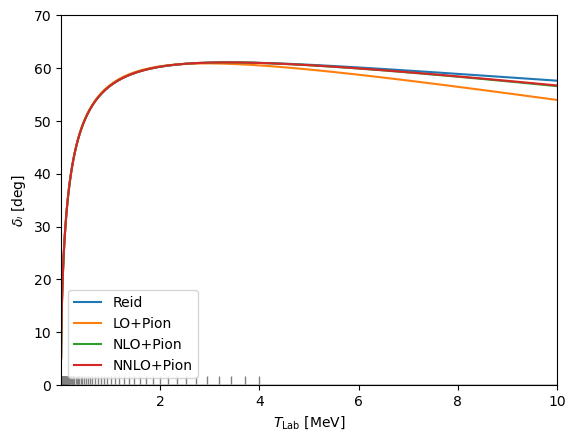

PyObject Text(28.000000000000007, 0.5, '$δₗ$ [deg]')

In [105]:
fig, ax = plt.subplots()
ax.plot(E, δReid, label="Reid")
ax.plot(E, δLO, label="LO+Pion")
ax.plot(E, δNLO, label="NLO+Pion")
ax.plot(E, δNNLO, label="NNLO+Pion")
ax.plot(E_fit, ones(length(E_fit)), "|", color="grey")

ax.legend()
ax.set_xlim(1e-3, 10)
ax.set_ylim(0, 70)
ax.axhline(y=0, c="k", linewidth=1)
ax.set_xlabel(L"$T_{\mathrm{Lab}}$ [MeV]")
ax.set_ylabel(L"$δₗ$ [deg]")

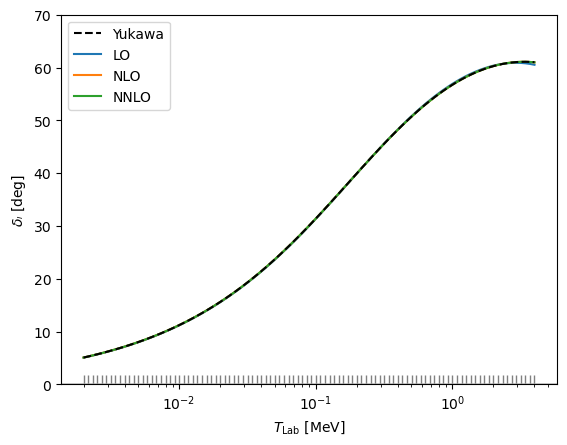

PyObject <matplotlib.legend.Legend object at 0x7fc8f9e42d30>

In [106]:
fig, ax = plt.subplots()
ax.plot(E_fit, δReid_fit, label="Yukawa", linestyle="--", c="k", zorder=10)
ax.plot(E_fit, δLO_fit, label="LO")
ax.plot(E_fit, δNLO_fit, label="NLO")
ax.plot(E_fit, δNNLO_fit, label="NNLO")
ax.plot(E_fit, ones(length(E_fit)), "|", color="grey")
ax.set_ylim(0, 70)
ax.axhline(y=0, c="k", linewidth=1)
ax.set_xlabel(L"$T_{\mathrm{Lab}}$ [MeV]")
ax.set_ylabel(L"$δₗ$ [deg]")
ax.set_xscale("log")
ax.legend()

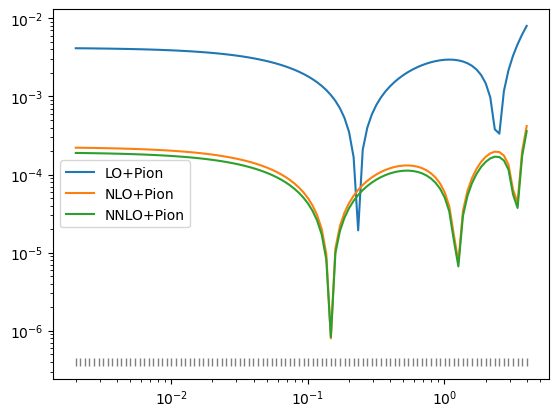

PyObject <matplotlib.legend.Legend object at 0x7fc8fb7ee550>

In [107]:
fig, ax = plt.subplots()
LO_err = @. abs(δReid_fit - δLO_fit)/δReid_fit
NLO_err = @. abs(δReid_fit - δNLO_fit)/δReid_fit
NNLO_err = @. abs(δReid_fit - δNNLO_fit)/δReid_fit
ax.plot(E_fit, LO_err, label="LO+Pion")
ax.plot(E_fit, NLO_err, label="NLO+Pion")
ax.plot(E_fit, NNLO_err, label="NNLO+Pion")
ax.set_yscale("log")
ax.set_xscale("log")
offset = (min([minimum(x) for x in [LO_err, NLO_err]]...)) / 2
ax.plot(E_fit, offset * ones(length(E_fit)), "|", color="grey")
ax.legend()

Study the impact of $V_{\pi}$

In [83]:
Vπs = -0.1:0.01:0.1
δs = []
for Vπ in Vπs
    V = regularize(LO(C0) + Pion(Vπ), 0.8)
    E, δ = rmatrix(V, endpoint=5)
    push!(δs, δ)
end

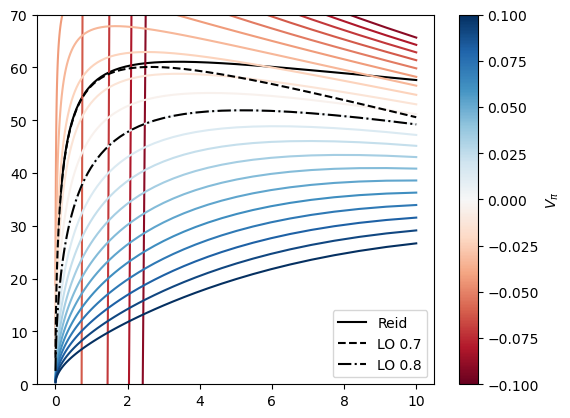

PyObject <matplotlib.colorbar.Colorbar object at 0x7fc8fa49c610>

In [85]:
fig, ax = plt.subplots()
cm = cmap("RdBu", length(Vπs))
E, δReid = rmatrix(Reid(), endpoint=5)
E, δLO = rmatrix(regularize(LO(C0), 0.8), endpoint=5)
E, δLO2 = rmatrix(regularize(LO(-0.53), 0.7), endpoint=5)

ax.plot(E, δReid, color="k", "-", label="Reid")
ax.plot(E, δLO2, color="k", "--", zorder=10, label="LO 0.7")
ax.plot(E, δLO, color="k", "-.", zorder=10, label="LO 0.8")
for i in 1:length(Vπs)
    ax.plot(E, δs[i], color=cm[i])
end
ax.set_ylim((0, 70))
ax.legend()
mpl = pyimport("matplotlib")
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=mpl.colors.Normalize(vmin=minimum(Vπs), vmax=maximum(Vπs)))
plt.colorbar(sm, ax=ax, label=L"$V_{\pi}$")

In [48]:
@show δLO

δLO = [33.209168211409406, 34.431819344873375, 35.674019110536165, 36.93360030231567, 38.20822051541513, 39.49537911327401, 40.79243778622883, 42.0966443600932, 43.40515937298723, 44.7150848139914, 46.02349431633846, 47.32746402830509, 48.62410335198293, 49.91058474623128, 51.18417183486948, 52.442245141121504, 53.682324878473544, 54.90209035852012, 56.09939571902767, 57.2722818210988, 58.418984304345415, 59.537937916077794, 60.627777339049096, 61.68733482876274, 62.71563503404324, 63.711887413737244, 64.67547667964129, 65.60595169378183, 66.5030132303632, 67.36650098271211, 68.19638015701018, 68.99272795086814, 69.75572016879151, 70.4856181806803, 71.18275638561225, 71.84753030251984, 72.48038537292501, 73.0818065290386, 73.6523085534151, 74.19242723386417, 74.70271129915726, 75.18371510684119, 75.63599204370006, 76.0600885916148, 76.4565390062637, 76.82586055282223, 77.16854924115896, 77.48507600256602, 77.77588325052152, 78.04138176904239, 78.28194787362335, 78.49792079136014, 78.68

100-element Array{Float64,1}:
 33.209168211409406
 34.431819344873375
 35.674019110536165
 36.93360030231567
 38.20822051541513
 39.49537911327401
 40.79243778622883
 42.0966443600932
 43.40515937298723
 44.7150848139914
 46.02349431633846
 47.32746402830509
 48.62410335198293
  ⋮
 66.40353506468745
 65.16127614400993
 63.821324564764005
 62.37584650304396
 60.81646810944018
 59.13432244954225
 57.32013488173191
 55.36436106037392
 53.257396151053506
 50.98987943937695
 48.55312551555564
 45.93972174900029

TODO:
- Name pionic interactions _pi
- Try Unitful
- Try larger fit interval for pions. 
- Generalize procedure
- Compare with/without pion